## Assignment I: AI318 Reinforcement Learning 

>- **Name:** **MAROUF** Imad Eddine

>- **Email:** imad.marouf@telecom-paris.fr

>- **Due to:** 24/01/2021

----------------------------------------------------------------------------

# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version. 

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have. 


In [44]:
import numpy as np
from model import Environment, Agent
from display import plot_regret


from scipy.stats import bernoulli
from math import log

import random
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

# Action generators 

In [60]:
seed = 42

def randomActionsGenerator(K,d):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size =K)
    norms = np.linalg.norm(vecs,axis=1)
    return vecs / norms[:,np.newaxis]

In [46]:
a = randomActionsGenerator(100,2)

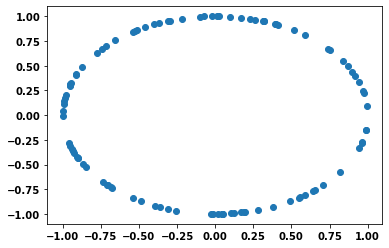

In [47]:
plt.scatter(a[:,0],a[:,1])

# Environment Class

In [48]:
class LinearBandit(Environment):
    
    def __init__(self, theta, K, model='gaussian', var=1.):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.model = model
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        
    def get_action_set(self):
        self.current_action_set = randomActionsGenerator(self.K, self.d)
        return self.current_action_set
        
    def get_reward(self, action):
    
        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        if self.model == 'gaussian':
            return np.random.normal(mean, scale=self.var)
        else:
            # Bernoulli distributed rewards
            #rewardBern = np.random.binomial(n=1, p=params[arm], size=size)
            return rewardBern
            
    def get_means(self):
        return np.dot(self.current_action_set, self.theta)

# Linear Bandit Agents

## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space. 

* 1 - **Baselines**: First implement a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Then, implement an LinEpsilonGreedy agent as seen in the previous Lab. 

> - **Do you think these agents can have a sublinear regret ?**
>> - Yes, theoretically, we know that LinUniform has linear regret and LinEpsilonGreedy has sublinear regret.

> - **Open question: Are they good baselines ?**
>> - **Answer:** Yes, we could consider them as good baselines to build first intuitions about our bandit problem (Although, they are not very sophisticated when it comes to providing optimal balance between exploration-exploitation tradeoff). LinUniform tries pick randomly a good actions, on the other hand LinEpsilonGreedy tries to take good actions with maximum reward, most of the time it get stuck at sub-optimal actions which gives good results comparing to LinUniform but it prevents from exploring other actions which could lead to better rewards on the long-run. 

* 2 - Implement LinUCB as studied in class: as for LinUCB, you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards. 

* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at round $t$... 
> - **Can you think of a way to optimize this step by simply updating the old one ?** 
> - Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v 
>> - **Answer:** By using  _Sherman–Morrison formula_
>>> - _Lemma:_ If $A$ and $A+B$ are _invertible_, and $B$ has rank 1, then let $g=trace(B.A−1)$. 
Then $g≠−1$ and $(A+B)^{−1} = A^{−1}− \frac{1}{1+g} * A^{−1}.B.A^{−1}$.



* 3 - It is common practice to modify LinUCB by multiplying the confidence bonus of each arm by some hyperparameter $ 0<\alpha <1 $. 
> - **What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ?**
>> - **Answer:** $\alpha$ values has an impact on the exploration-exploitation of the model, it should be set diligently by tuning (i.e: it increases incentives for exploration or exploitation). If it $\alpha = 0 $, the algorithm becomes greedier it privelages exploitation rather than searching for other possibly optimal action, which may lead the agent into being stuck at sub-optimal action.

> - Implement this little modification and compare the results for several values of $\alpha$ (see further down for experiments scripts).



In [49]:
class LinUniform(Agent):
    def __init__(self):
        pass

    def get_action(self, arms):
        K, _ = arms.shape
        return arms[np.random.choice(K)]

    def receive_reward(self, chosen_arm, reward):
        pass

    def reset(self):
        pass

    #@staticmethod
    def name(self):
        return 'Unif'

In [50]:
class LinEpsilonGreedy(Agent):
    def __init__(self, d, lambda_reg, epsilon, label="LinEpsilonGreedy"):
        self.epsilon = epsilon
        self.d = d
        self.lambda_reg = lambda_reg
        self.label = label
        self.reset()
        
    def get_action(self, arms):
        if np.random.random() < self.epsilon :
            theta = np.dot(self.V_inv, self.b)
            y_hats = [np.dot(theta, a) for a in arms]
            return arms[np.argmax(y_hats)]
        else : 
            return arms[np.random.randint(arms.shape[0])]

    def receive_reward(self, chosen_arm, reward):
        outer_product = np.outer(chosen_arm,chosen_arm)
        factor = 1 + np.dot(chosen_arm, np.dot(self.V_inv, chosen_arm))
        self.V_inv -= np.dot(self.V_inv, np.dot(outer_product, self.V_inv))/factor #Sherman-Morrison formula
        self.b += reward*chosen_arm

    def reset(self):
        self.V_inv = np.diag(np.ones(self.d)/self.lambda_reg)
        self.b = np.zeros(self.d)

    def name(self):
        return self.label

In [51]:
from numpy.linalg import pinv

class LinUCB(Agent):
    def __init__(self, T, d, delta, lambda_reg, alpha = 1, label="LinUCB"):
        """
        TODO: describe inputs 
        TODO: add an input alpha to optionally scale the exploration bonus in the get_action function
        """
        self.T = T
        self.d = d
        self.delta = delta
        self.lambda_reg = lambda_reg
        
        ### TODO
        self.alpha = alpha
        self.label = label
        self.cov = self.lambda_reg * np.identity(d)
        lmbd = np.sqrt(self.lambda_reg)
        cst = 2 * (np.log(1 / self.delta))
        self.beta = [(lmbd) + np.sqrt(cst + self.d * np.log((self.lambda_reg * self.d + t) / self.lambda_reg * self.d)) for t in range(1, self.T)]
        
        #Re-setting the parameters
        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        ### TODO
        self.tild_theta = np.zeros(self.d)
        self.cov = self.lambda_reg * np.identity(self.d)
        self.invcov = np.identity(self.d)
        self.previous = np.zeros(self.d)


    def get_action(self, arms):
        """
            This function implements LinUCB
            Input:
            -------
            arms : list of arms (d-dimensional vectors)

            Output:
            -------
            chosen_arm : index of the pulled arm
            """
        # compute the UCB of each of the arm in arms, here arms are vectors
        # ucbs = np.array(K)

        # for i in range(K):
        # ucbs[i] = 1# use hat_theta and beta and the covariance matrix. 
        #  beta_n is the upper bound given at the very end of the class

        K, _ = arms.shape
        self.UCBs = np.zeros(K)

        ### TODO
        for index_arm in range(K):
            a = arms[index_arm, :]
            covxa = np.inner(self.invcov, a.T)
            # Multiply the confidence bonus by alpha
            self.UCBs[index_arm] = np.dot(self.tild_theta, a) + self.alpha * self.beta[self.t - 1 ] * np.sqrt((np.dot(a, covxa)))
        
        index = np.argmax(self.UCBs)
        chosen_arm = arms[index]
        AAt = np.outer(chosen_arm, chosen_arm.T)
        self.cov += AAt
        self.invcov = pinv(self.cov)  
        
        return chosen_arm
        #     return np.random.choice(K)

    def receive_reward(self, chosen_arm, reward):
        ### TODO
        self.previous += reward * chosen_arm 
        #Inner product
        self.tild_theta = np.inner(self.invcov, self.previous)
        self.t += 1
        pass 
    
    def name(self):
        return self.label

--------------------------------------------------------------------------------------

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* 1-  Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\sigma_0 I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, 
> - **Can you compute the expression of the posterior at the beginning of round $t+1$ ?**
>> - **Answer:**

Let $f$ be the PDF of $\theta$ prior distribution, $\pi$, such that $\pi \sim \mathcal{N}(\mu_0, \Sigma_0)$. After observation $A, Y$, the $log$ of $\theta$ posterior distribution's PDF is given by :
$$
\begin{align}
\log (f(Y|\theta, A)f(\theta)) + cste &=  -\frac{1}{2}(\theta - \mu_0)^T\Sigma_0^{-1}(\theta - \mu_0) - \frac{1}{2\sigma^2}(Y - A^T\theta)^T(Y - A^T\theta) + cste\\
&= -\frac{1}{2}[\theta^T(\Sigma_0^{-1}+\frac{1}{\sigma^2}AA^T)\theta - 2\theta^T(\Sigma_0^{-1}\mu_0 + \frac{Y}{\sigma^2}A)] + cste
\end{align}
$$
Now, let us denote 
$$
\begin{align}
\Sigma^{-1} &= &\Sigma_0^{-1}+\frac{1}{\sigma^2}AA^T \\
\mu &= &\Sigma(\Sigma_0^{-1}\mu_0 + \frac{Y}{\sigma^2}A)
\end{align}
$$
The $log$ of $\theta$ posterior distribution's PDF is now given by :
$$
\begin{align}
-\frac{1}{2}[\theta^T\Sigma^{-1}\theta - 2\theta^T\Sigma^{-1}\mu] + cste &= -\frac{1}{2}[\theta^T\Sigma^{-1}\theta - 2\theta^T\Sigma^{-1}\mu + \mu^T\mu] + cste \\
& = -\frac{1}{2}(\theta - \mu)^T\Sigma^{-1}(\theta - \mu) + cste
\end{align}
$$
which proves that $\theta$ posterior distribution follows $\mathcal{N}(\mu, \Sigma)$.

Now, let us denote by $\pi_t$ $\theta$'s distribution at the begining of round $t$. We proved that for all $t\geq0$, $\pi_{t+1} \sim \mathcal{N}(\mu_{t+1}, \Sigma_{t+1})$ such that :
$$\begin{align}
\Sigma_{t+1}^{-1} &= \Sigma_{t}^{-1}+\frac{1}{\sigma^2}A_tA_t^T = \frac{1}{\sigma_0^2}I + \frac{1}{\sigma^2}\sum\limits_{i=1}^t A_iA_i^T \\
\Sigma_{t+1}^{-1}\mu_{t+1} &= \Sigma_{t}^{-1}\mu_{t} + \frac{Y_t}{\sigma^2}A_t =\frac{1}{\sigma^2}\sum\limits_{i=1}^t Y_iA_i
\end{align}$$

>> - Thus, for all $t \geq 1$, samplig for $\theta$ is done according to the distribution $\pi_t \sim N(\mu, \Sigma_{t})$, where: 
>>> - $$\Sigma_{t} = (\frac{1}{\delta_{0}^2} I_{d} + \frac{1}{\delta^2} \Sigma_{i=1}^{t-1} A_{i} A_{i}^T)^{-1}$$
>>> - $$\mu_{t} = \frac{1}{\delta^2} \Sigma_{t} (\Sigma_{i=1}^{t-1} Y_{i} A_{i}) $$


* 2- Implement a LinTS (Linear Thompson Sampling) agent and run it against LinUCB and LinUCB with some $alpha$ scaling parameter (see further down).

**Strategy:**
> - 1. Sample a random variable $X_b$ from the prior of bandit $b$, for all b.
> - 2. Select the bandit with largest sample, i.e. select bandit $B$ = $argmax$($X_b$).
> - 3. Observe the result of pulling bandit  $B$, and update your prior on bandit $B$ using the conjugate model update rule.
> - 4. Repeat.


In [52]:
from numpy.linalg import pinv

class LinTS(Agent):
    def __init__(self, T, d, sigma, sigma_init, label="LinTS"):
        self.T = T
        self.d = d
        self.sigma = sigma
        
        ### TODO
        self.sigma_init = sigma_init
        self.label = label
        
        #Re-setting the parameters
        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        ### TODO
        self.tild_theta = np.zeros(self.d)
        self.cov = (1/self.sigma_init**2) * np.identity(self.d)
        self.mu = np.zeros(self.d)
        self.previous = np.zeros(self.d) 

    def get_action(self, arms):
        """
            This function implements LinTS
            Input:
            -------
            arms : list of arms (d-dimensional vectors)

            Output:
            -------
            chosen_arm : index of the pulled arm
            """
        # compute the UCB of each of the arm in arms, here arms are vectors
        # ucbs = np.array(K)

        # for i in range(K):
        # ucbs[i] = 1# use hat_theta and beta and the covariance matrix. 
        #  beta_n is the upper bound given at the very end of the class

        K, _ = arms.shape
        self.UCBs = np.zeros(K)

        ### TODO
        for index_arm in range(K):
            a = arms[index_arm, :]
            self.UCBs[index_arm] = np.dot(self.tild_theta, a)
        
        index = np.argmax(self.UCBs)
        chosen_arm = arms[index]
        
        outer_product = (1/(self.sigma**2)) * (np.outer(chosen_arm, chosen_arm.T))
        fraction = 1 + np.dot(chosen_arm, np.dot(self.cov, chosen_arm))
        self.cov -= (1 / fraction) * np.dot(self.cov, np.dot(outer_product, self.cov))
        
        return chosen_arm

    def receive_reward(self, chosen_arm, reward):
        ### TODO
        self.previous += reward * chosen_arm 
        
        #Pick tild_theta
        self.mu = (1/(self.sigma**2)) * self.previous
        mean_t = np.dot(self.cov, self.mu) 
        
        self.tild_theta = np.random.multivariate_normal(mean_t, self.cov)
        self.t += 1
        pass 
    
    def name(self):
        return self.label

# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [53]:
def play(environment, agent, Nmc, T):
    data = np.zeros((Nmc, T))
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            
            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - reward
            
    return agent.name(), data

def experiment(environment, agents, Nmc, T):
    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

--------------------------------------------------------------------------------------

# 1 -  Example: LinUCB versus LinUniform

- Before delving into the analysis of experiments we need to fix the seed for generating distributions.

In [22]:
seed = 42
np.random.seed(42)

In [13]:
# import time

d = 2  # dimension
K = 8  # number of arms

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)

#theta = randomActionsGenerator(1, d)

T = 100  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10

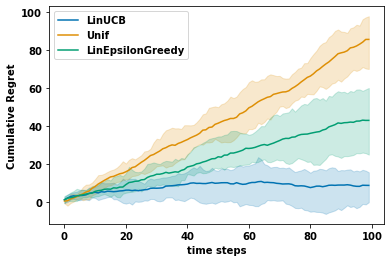

In [14]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinUniform()
agent3 = LinEpsilonGreedy(d, lambda_reg = 1., epsilon = 0.5)

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=N, T=T)

plot_regret(all_data)

#### _You should get a straight diagonal line for Unif and a nice, almost flat curve for LinUCB._
**Condition: SATISFIED**

**Comment:**
> - As seen in the lecture, LinUCB outperforms both LinUniform, and LinEpsilonGreedy. Since the former, picks actions randomly, not a good stategy to maximize the rewards, while the later is greedy by taking only action which maximized the reward which could be sub-optimal preventing the agent from exploring other actions which could be more optimal. 


### 1.1 - Discussion:  Experimenting with Parameter $\lambda_{reg}$ 

- LinUCB takes as input a parameter $\lambda_{reg}$ that controls the regularisation in the least squares estimation. Choosing it is not easy and to the best of my knowledge there is no clear rule... but maybe we could see experimentally if it impacts the results. 

- Run a few LinUCB with different $\lambda_{reg}$ values and plot the results. Beware ! You will have to modify the function "name()" of LinUCB to include the chosen value, otherwise the plotting function will overwrite each curve (this holds for the next experiments as well).

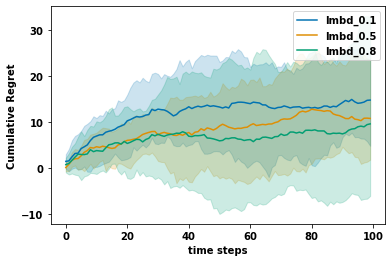

In [208]:
basicGaussianBandit = LinearBandit(theta, K)
#....TODO
agent1 = LinUCB(T, d, delta, lambda_reg=0.1, label="lmbd_0.1")
agent2 = LinUCB(T,d, delta, lambda_reg=0.5, label="lmbd_0.5")
agent3 = LinUCB(T, d, delta, lambda_reg=0.8, label="lmbd_0.8")

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=10, T=100)

plot_regret(all_data)

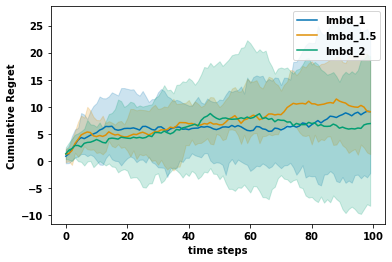

In [209]:
basicGaussianBandit = LinearBandit(theta, K)
#....TODO
agent1 = LinUCB(T,d, delta, lambda_reg=1, label="lmbd_1")
agent2 = LinUCB(T,d, delta, lambda_reg=1.5, label="lmbd_1.5")
agent3 = LinUCB(T,d, delta, lambda_reg=2, label="lmbd_2")

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=10, T=100)

plot_regret(all_data)

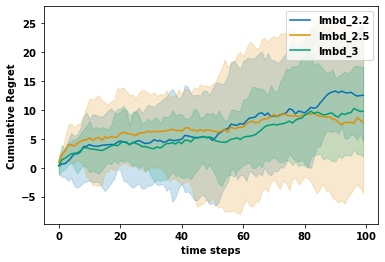

In [210]:
basicGaussianBandit = LinearBandit(theta, K)
#....TODO
agent1 = LinUCB(T,d, delta, lambda_reg=2.2, label="lmbd_2.2")
agent2 = LinUCB(T,d, delta, lambda_reg=2.5, label="lmbd_2.5")
agent3 = LinUCB(T,d, delta, lambda_reg=3, label="lmbd_3")

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=10, T=100)

plot_regret(all_data)

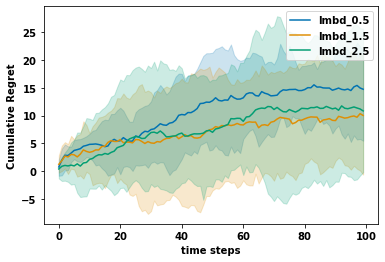

In [211]:
basicGaussianBandit = LinearBandit(theta, K)
#....TODO
agent1 = LinUCB(T,d, delta, lambda_reg=0.5, label="lmbd_0.5")
agent2 = LinUCB(T,d, delta, lambda_reg=1.5, label="lmbd_1.5")
agent3 = LinUCB(T,d, delta, lambda_reg=2.5, label="lmbd_2.5")

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=10, T=100)

plot_regret(all_data)

**Comment:**
> - $\lambda_{reg}$ is a regularization hyperparameter for LSE. Thus, it prevents the model from overfitting, to all fit the data samples. It should be tunned correctly in order to provide an optimal balance between variance-bias.
> - The model is very stochastic which makes very difficult to pick the right value for $\lambda_{reg}$, and the confidence intervals are very large. But roughly, mostly in the literature it has 0.1 value.

## 1.2- LinUCB with $\alpha$ scaling



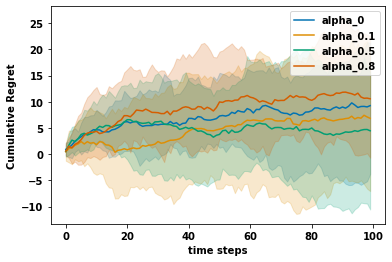

In [225]:
basicGaussianBandit = LinearBandit(theta, K)

agent1 = LinUCB(T, d, delta, lambda_reg=0.1, alpha = 0, label="alpha_0")
agent2 = LinUCB(T, d, delta, lambda_reg=0.1, alpha = 0.1, label="alpha_0.1")
agent3 = LinUCB(T,d, delta, lambda_reg=0.1, alpha=0.5, label="alpha_0.5")
agent4 = LinUCB(T,d, delta, lambda_reg=0.1, alpha=0.8, label="alpha_0.8")

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3, agent4], Nmc=10, T=100)

plot_regret(all_data)

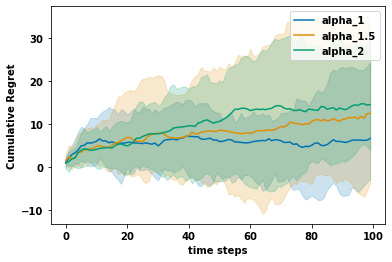

In [220]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=0.1, alpha = 1, label="alpha_1")
agent2 = LinUCB(T,d, delta, lambda_reg=0.1, alpha=1.5, label="alpha_1.5")
agent3 = LinUCB(T,d, delta, lambda_reg=0.1, alpha=2, label="alpha_2")

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=10, T=100)

plot_regret(all_data)

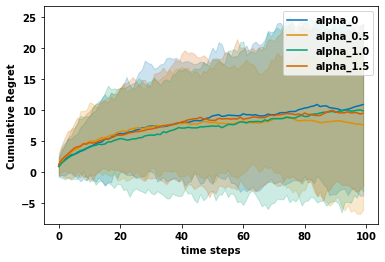

In [235]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=0.1, alpha = 0, label="alpha_0")
agent2 = LinUCB(T, d, delta, lambda_reg=0.1, alpha = 0.1, label="alpha_0.5")
agent3 = LinUCB(T,d, delta, lambda_reg=0.1, alpha=1.0, label="alpha_1.0")
agent4 = LinUCB(T,d, delta, lambda_reg=0.1, alpha=1.5, label="alpha_1.5")

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3, agent4], Nmc=50, T=100)

plot_regret(all_data)

### Discussion : 

**_Please comment on your results briefly. Do they validate your hypotheses or not ? Why ?_**

**Comment:**
> - Yes, as stated above, indeed $\alpha $ it effects the behavior of LinUCB, where for small values the agent becomes more inclined towards exploitation becoming more greedy. 

------------------------------------------------------------------------------------------------

# 2-  LinTS versus LinUCB


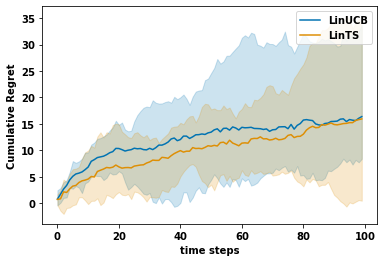

In [285]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinTS(T, d, sigma = 1, sigma_init = 1, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], N, T)

plot_regret(all_data)

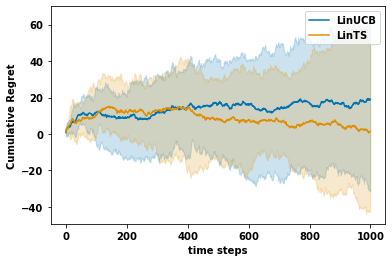

In [289]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(1000, d, delta, lambda_reg=1.)
agent2 = LinTS(1000, d, sigma = 1, sigma_init = 1, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], N, 1000)

plot_regret(all_data)

### 2.1 Experimenting with Parameters $\sigma_{0}$ \& $\sigma$ for LinTS

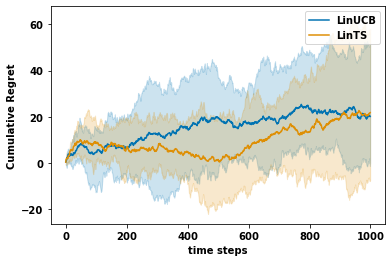

In [292]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(1000, d, delta, lambda_reg=1.)
agent2 = LinTS(1000, d, sigma = 1, sigma_init = 0.01, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], N, 1000)

plot_regret(all_data)

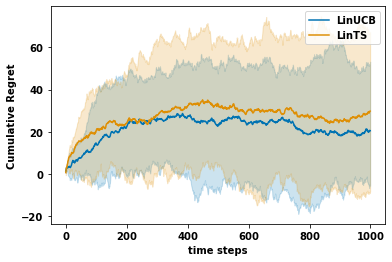

In [294]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(1000, d, delta, lambda_reg=1.)
agent2 = LinTS(1000, d, sigma = 1, sigma_init = 5, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], N, 1000)

plot_regret(all_data)

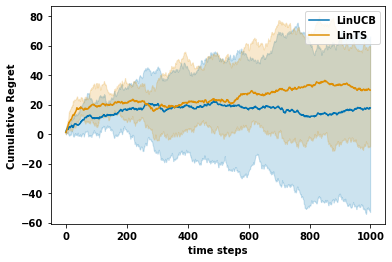

In [297]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(1000, d, delta, lambda_reg=1.)
agent2 = LinTS(1000, d, sigma = 2, sigma_init = 1, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], N, 1000)

plot_regret(all_data)

**Comment:**
> - Initial values $\sigma_{0}$ and $\sigma$ for LinTS Algorithm has a major impact on its performance.
> - Thompson Sampling like LinUCB is also asymptotically optimal for Gaussian with unknown mean and variance [Honda and Takemura, 14]

### Long-Term Horizon (LinUCB versus LinTS):

#### $\sigma_{0}$ = [0.1, 0.05, 0.01]

Long horizon, T = 10000 (average over N = 100 runs)

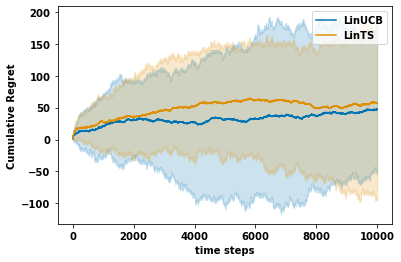

In [64]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(10000, d, delta, lambda_reg=1.)
agent2 = LinTS(10000, d, sigma = 1, sigma_init = 0.1, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], 50, 10000)

plot_regret(all_data)

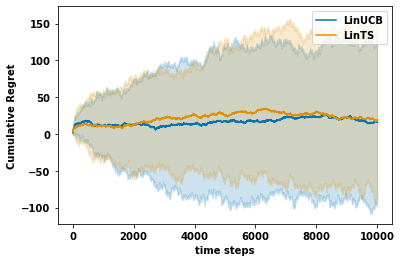

In [65]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(10000, d, delta, lambda_reg=1.)
agent2 = LinTS(10000, d, sigma = 1, sigma_init = 0.05, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], 50, 10000)

plot_regret(all_data)

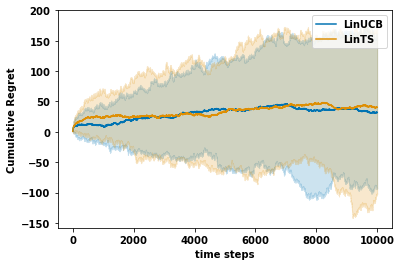

In [66]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(10000, d, delta, lambda_reg=1.)
agent2 = LinTS(10000, d, sigma = 1, sigma_init = 0.01, label="LinTS")
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], 50, 10000)

plot_regret(all_data)

**Comment:**
> - Both LinUCB, LinTS it seems do good when the assumption that the reward distribution belong to Gaussian, but in the literature it was proven that LinTS outperforms LinUCB when the distribution is Bernolli.[Honda and Takemura, 14]

### Discussion : 

**_Please comment on your results briefly. Do they validate your hypotheses or not ? Why ?_**

**Comment:**
> - Thompson sampling is really interesting algorithm, where it gives an optimal balance between exploitation-exploration trade-off, which makes it not greedy. It outperforms LinUCB in most cases.

> - An interesting phenomena, we notice is that mostly LinUCB outperforms LinTS at the beginning of iterations, due to the that LinUCB exploits bandits which gave best mean rewards, on the otherhand LinTS gives an optimal balance between exploitation-exploration, it exploits some good actions, and check other actions which could be optimal. If they are not their frequency of using used will be reduced in the following iterations. Which makes a powerful algorithm for recommendation systems (we would like to give users best recommendations to maximize rewards, at the same time, we want to explore other user's preferences). 

> - Although Thompson Sampling is very powerful, it has some pitfalls like: 
>> - It depends on some parameters (like noise, sigma) which are hypothesis in our case -Difficult to know their exact values-. As illustrated in the last experiments depending on those hyperparameters, somestimes LinUCB outperforms LinTS.
>> - It depends on the a critical hypothesis we have to make regarding the type of distribution of $\theta$. For instance, in our case the chosen was _Gaussian_ although it can be any other type of distribution ( _Bernolli distribtuion_ ).